In [1]:
import glob
import pandas as pd

data_files = glob.glob("chess_ratings/*.csv")
all_dfs = [pd.read_csv(file, sep='|') for file in data_files]

/tmp/ipykernel_40212/750563276.py:5: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  all_dfs = [pd.read_csv(file, sep='|') for file in data_files]


In [2]:
data = pd.concat(all_dfs)
del all_dfs
data["Year / month"] = [f"{y} / {m if (len(str(m)) == 2) else ('0' + str(m))}" for y, m in zip(data["Year"], data["Mon"])]

data['age'] = (2019 - data['B-day']).astype('int')
data = data[(data['age'] > 5) & (data['age'] < 110)].copy()

In [3]:
# unify flag columns
data.loc[data['Flag'] == 'wi', 'Flag'] = 'i'
data.loc[data['Flag'] == 'w', 'Flag'] = ''

In [4]:
string_cols = ['Name', 'Tit', 'WTit', 'OTit', 'FOA', 'Flag']

data[string_cols] = data[string_cols].fillna('')

In [5]:
female_tit = ["None", "WCM", "WFM", "WIM", "WGM"]
tit = ["None", "CM", "FM", "IM", "GM"]

female_tit = {t: i for i, t in enumerate(female_tit)}
tit = {t: i for i, t in enumerate(tit)}

data['tit'] = [(0 if t not in tit else tit[t]) for t in data['Tit']]
data['wtit'] = [(0 if t not in female_tit else female_tit[t]) for t in data['Tit']]

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "20g") \
    .appName('chess-app') \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/18 13:07:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
#smol = data[data["ID Number"] > 100000000]
#smol = data.drop(columns=['Name', 'Fed', 'Sex', 'B-day', 'Year / month'])
smol = data


spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

df = spark.createDataFrame(smol)
df

DataFrame[ID Number: bigint, Name: string, Fed: string, Sex: string, Tit: string, WTit: string, OTit: string, FOA: string, Rat: bigint, Gms: bigint, K: bigint, B-day: bigint, Flag: string, Year: bigint, Mon: bigint, Year / month: string, age: bigint, tit: bigint, wtit: bigint]

In [8]:
df.show(5)

22/05/18 13:02:51 WARN TaskSetManager: Stage 0 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.


+---------+----------------+---+---+---+----+----+---+----+---+---+-----+----+----+---+------------+---+---+----+
|ID Number|            Name|Fed|Sex|Tit|WTit|OTit|FOA| Rat|Gms|  K|B-day|Flag|Year|Mon|Year / month|age|tit|wtit|
+---------+----------------+---+---+---+----+----+---+----+---+---+-----+----+----+---+------------+---+---+----+
| 35077023|  A Chakravarthy|IND|  M|   |    |    |   |1151|  0| 40| 1986|   i|2018|  8|   2018 / 08| 33|  0|   0|
| 10207538|A E M, Doshtagir|BAN|  M|   |    |    |   |1840|  0| 40| 1974|   i|2018|  8|   2018 / 08| 45|  0|   0|
|  5716365| A Hamid, Harman|MAS|  M|   |    |  NI|   |1325|  6| 40| 1970|    |2018|  8|   2018 / 08| 49|  0|   0|
|  5045886|   A K, Kalshyan|IND|  M|   |    |    |   |1826| 10| 20| 1964|    |2018|  8|   2018 / 08| 55|  0|   0|
|  8605360|  A La, Teng Hua|CHN|  F|   |    |    |   |1915|  0| 40| 1993|   i|2018|  8|   2018 / 08| 26|  0|   0|
+---------+----------------+---+---+---+----+----+---+----+---+---+-----+----+----+---+-

In [11]:
import numpy as np
from spark_utils import get_mean, get_sum, get_string, reduce_by_months, get_max


In [25]:
red = reduce_by_months(df, 'Rat', get_mean, agg_func_name='mean', n_months=12) \
        .groupBy('ID Number') \
        .pivot('Colname') \
        .max('Rat:mean')

red.show(5)

22/05/18 12:27:31 WARN TaskSetManager: Stage 762 contains a task of very large size (31371 KiB). The maximum recommended task size is 1000 KiB.


+---------+---------------------+---------------------+---------------------+
|ID Number|Rat:mean/2017//yearly|Rat:mean/2018//yearly|Rat:mean/2019//yearly|
+---------+---------------------+---------------------+---------------------+
| 42507359|               1577.0|               1577.0|   1529.3333333333333|
|   928453|               2048.0|               2048.0|   2047.3333333333333|
|  3520005|               2033.0|               2033.0|               2033.0|
| 24646245|               1742.0|               1742.0|               1742.0|
| 46628100|               1466.0|               1466.0|               1466.0|
+---------+---------------------+---------------------+---------------------+
only showing top 5 rows



In [26]:
red = reduce_by_months(df, 'Gms', get_sum, agg_func_name='sum', n_months=6) \
        .groupBy('ID Number') \
        .pivot('Colname') \
        .max('Gms:sum')

red.show(5)

22/05/18 12:27:52 WARN TaskSetManager: Stage 782 contains a task of very large size (31371 KiB). The maximum recommended task size is 1000 KiB.


+---------+-----------------+----------------+-----------------+----------------+----------------+-----------------+----------------+
|ID Number|Gms:sum/2017/12/6|Gms:sum/2018/0/6|Gms:sum/2018/12/6|Gms:sum/2018/6/6|Gms:sum/2019/0/6|Gms:sum/2019/12/6|Gms:sum/2019/6/6|
+---------+-----------------+----------------+-----------------+----------------+----------------+-----------------+----------------+
|   352217|                0|               0|                0|               0|               0|                0|               0|
| 44560974|             null|            null|                0|               7|               0|                0|               0|
| 16246144|                0|               7|                0|               0|              16|                0|               8|
| 21834318|                0|               0|                0|               0|               7|                0|               0|
| 46695168|                0|               0|                

In [27]:
red = reduce_by_months(df, 'Gms', get_sum, agg_func_name='sum', n_months=12) \
        .groupBy('ID Number') \
        .pivot('Colname') \
        .max('Gms:sum')

red.show(5)

22/05/18 12:28:11 WARN TaskSetManager: Stage 802 contains a task of very large size (31371 KiB). The maximum recommended task size is 1000 KiB.


+---------+--------------------+--------------------+--------------------+
|ID Number|Gms:sum/2017//yearly|Gms:sum/2018//yearly|Gms:sum/2019//yearly|
+---------+--------------------+--------------------+--------------------+
| 54507332|                   0|                  23|                  11|
| 12980927|                   0|                   0|                   0|
|   928453|                   2|                   5|                   7|
|  5502276|                null|                   8|                   6|
|  2180740|                   0|                   0|                   0|
+---------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [14]:
red = reduce_by_months(df, 'tit', get_max, agg_func_name='max', n_months=12) \
        .groupBy('ID Number') \
        .pivot('Colname').max('tit:max')

red.show(5)

22/05/18 13:31:43 WARN TaskSetManager: Stage 44 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.


+---------+--------------------+--------------------+--------------------+
|ID Number|tit:max/2017//yearly|tit:max/2018//yearly|tit:max/2019//yearly|
+---------+--------------------+--------------------+--------------------+
|  1662180|                   0|                   0|                   0|
|  9947876|                   0|                   0|                   0|
|  4168836|                   0|                   0|                   0|
| 24628255|                   0|                   0|                   0|
| 24630047|                   0|                   0|                   0|
+---------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [40]:
data['Tit'].unique()

array(['', 'WFM', 'IM', 'GM', 'WIM', 'FM', 'CM', 'WCM', 'WGM', 'WH'],
      dtype=object)

In [20]:
df.drop_duplicates().show(5)

+---------+------------------+---+---+---+----+----+---+----+---+---+-----+----+----+---+------------+
|ID Number|              Name|Fed|Sex|Tit|WTit|OTit|FOA| Rat|Gms|  K|B-day|Flag|Year|Mon|Year / month|
+---------+------------------+---+---+---+----+----+---+----+---+---+-----+----+----+---+------------+
|137122537|   Tonoyan, Robert|FID|  M|   |    |    |   |1880|  2| 20| 1994|    |2018|  4|   2018 / 04|
|551012243|Jourd`hui, Trystan|FRA|  M|   |    |    |   |1184|  0| 40| 2004|    |2018|  5|   2018 / 05|
|366196523|  Kulkarni, Rakesh|IND|  M|   |    |    |AIM|1340|  0| 40| 1984|    |2018|  5|   2018 / 05|
|551000067|  Pironti, Nicolas|FRA|  M|   |    |    |   |1353|  1| 40| 1958|    |2018|  5|   2018 / 05|
|551013886|    Poirson, Simon|FRA|  M|   |    |    |   |1333|  0| 40| 2003|    |2018|  5|   2018 / 05|
+---------+------------------+---+---+---+----+----+---+----+---+---+-----+----+----+---+------------+
only showing top 5 rows



In [36]:
from spark_utils import get_dataset
from model_utils import x_y_split

In [37]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# feature_cols = [('Gms', 'sum'), ('Tit', 'str')]

feature_cols = [('Flag', 'str'), ('Gms', 'sum'), ('Gms', 'mean'), ('Rat', 'mean'), ('tit', 'max'), ('wtit', 'max')]

pdf = get_dataset(df, feature_cols)

22/05/18 14:35:43 WARN TaskSetManager: Stage 972 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.
22/05/18 14:35:58 WARN TaskSetManager: Stage 983 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.
22/05/18 14:36:03 WARN TaskSetManager: Stage 998 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.


Counts before join: base_df 345770, reduced 345770


22/05/18 14:36:06 WARN TaskSetManager: Stage 1010 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.


Counts after join: base_df 345770


22/05/18 14:36:20 WARN TaskSetManager: Stage 1021 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.
22/05/18 14:36:27 WARN TaskSetManager: Stage 1042 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.


Counts before join: base_df 345770, reduced 345770


22/05/18 14:36:31 WARN TaskSetManager: Stage 1060 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.


Counts after join: base_df 345770


22/05/18 14:36:48 WARN TaskSetManager: Stage 1071 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.
22/05/18 14:36:55 WARN TaskSetManager: Stage 1098 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.


Counts before join: base_df 345770, reduced 345770


22/05/18 14:37:01 WARN TaskSetManager: Stage 1122 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.


Counts after join: base_df 345770


22/05/18 14:37:16 WARN TaskSetManager: Stage 1133 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.
22/05/18 14:37:24 WARN TaskSetManager: Stage 1166 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.


Counts before join: base_df 345770, reduced 345770


Counts after join: base_df 345770


22/05/18 14:37:32 WARN TaskSetManager: Stage 1196 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.
22/05/18 14:37:46 WARN TaskSetManager: Stage 1207 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.
22/05/18 14:37:54 WARN TaskSetManager: Stage 1246 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.


Counts before join: base_df 345770, reduced 345770


Counts after join: base_df 345770


22/05/18 14:38:04 WARN TaskSetManager: Stage 1282 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.
22/05/18 14:38:18 WARN TaskSetManager: Stage 1293 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.
22/05/18 14:38:28 WARN TaskSetManager: Stage 1338 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.


Counts before join: base_df 345770, reduced 345770


Counts after join: base_df 345770


In [38]:
pdf.show(5)
pdf = pdf.toPandas()

22/05/18 14:38:38 WARN TaskSetManager: Stage 1380 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.
22/05/18 14:38:49 WARN TaskSetManager: Stage 1427 contains a task of very large size (35211 KiB). The maximum recommended task size is 1000 KiB.


+---------+---+---+---+----+---------------------+---------------------+---------------------+--------------------+--------------------+--------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+--------------------+--------------------+--------------------+---------------------+---------------------+---------------------+
|ID Number|Sex|  K|age|Flag|Flag:str/2017//yearly|Flag:str/2018//yearly|Flag:str/2019//yearly|Gms:sum/2017//yearly|Gms:sum/2018//yearly|Gms:sum/2019//yearly|Gms:mean/2017//yearly|Gms:mean/2018//yearly|Gms:mean/2019//yearly|Rat:mean/2017//yearly|Rat:mean/2018//yearly|Rat:mean/2019//yearly|tit:max/2017//yearly|tit:max/2018//yearly|tit:max/2019//yearly|wtit:max/2017//yearly|wtit:max/2018//yearly|wtit:max/2019//yearly|
+---------+---+---+---+----+---------------------+---------------------+---------------------+--------------------+--------------------+--------------------+-----

In [44]:
pdf

,ID Number,Sex,K,age,Flag:str/2017//yearly,Flag:str/2018//yearly,Flag:str/2019//yearly,Gms:sum/2017//yearly,Gms:sum/2018//yearly,Gms:sum/2019//yearly,...,Gms:mean/2019//yearly,Rat:mean/2017//yearly,Rat:mean/2018//yearly,Rat:mean/2019//yearly,tit:max/2017//yearly,tit:max/2018//yearly,tit:max/2019//yearly,wtit:max/2017//yearly,wtit:max/2018//yearly,wtit:max/2019//yearly
0,100170,M,20,28,i,i,i,0.0,0.0,0.0,...,0.000000,1930.0,1930.000000,1930.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,100323,M,10,59,i,i,i,0.0,0.0,0.0,...,0.000000,2389.0,2389.000000,2389.000000,3.0,3.0,3.0,0.0,0.0,0.0
2,100552,M,10,59,,,,7.0,16.0,36.0,...,3.000000,2403.0,2397.666667,2376.666667,2.0,2.0,2.0,0.0,0.0,0.0
3,101435,M,20,96,i,i,i,0.0,0.0,0.0,...,0.000000,2310.0,2310.000000,2310.000000,3.0,3.0,3.0,0.0,0.0,0.0
4,101583,M,40,49,i,i,i,0.0,0.0,0.0,...,0.000000,2237.0,2237.000000,2237.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345765,551037335,M,40,10,i,i,,0.0,0.0,10.0,...,1.000000,0.0,0.000000,1021.400000,0.0,0.0,0.0,0.0,0.0,0.0
345766,551040239,M,40,13,i,i,,0.0,0.0,21.0,...,3.500000,0.0,0.000000,1481.500000,0.0,0.0,0.0,0.0,0.0,0.0
345767,551040247,M,40,13,i,i,,0.0,0.0,14.0,...,1.750000,0.0,0.000000,1043.875000,0.0,0.0,0.0,0.0,0.0,0.0
345768,551055252,M,40,11,i,i,,0.0,0.0,16.0,...,1.777778,0.0,0.000000,1061.888889,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
for c in pdf.columns:
    if 'Flag' in c:
        pdf[c] = pdf[c].fillna('i')
    else:
        pdf[c] = pdf[c].fillna(0)

In [68]:
from model_utils import x_y_split

xorig, yorig = x_y_split(pdf, last_year='2019')

In [69]:
from model_utils import cut_age_groups

cut_age_groups(xorig, bins='groups')

In [70]:
xorig

,ID Number,Sex,K,age,Flag:str/2017//yearly,Flag:str/2018//yearly,Gms:sum/2017//yearly,Gms:sum/2018//yearly,Gms:mean/2017//yearly,Gms:mean/2018//yearly,Rat:mean/2017//yearly,Rat:mean/2018//yearly,tit:max/2017//yearly,tit:max/2018//yearly,wtit:max/2017//yearly,wtit:max/2018//yearly
0,100170,M,20,"(25, 35]",i,i,0.0,0.0,0.0,0.000000,1930.0,1930.000000,0.0,0.0,0.0,0.0
1,100323,M,10,"(50, 65]",i,i,0.0,0.0,0.0,0.000000,2389.0,2389.000000,3.0,3.0,0.0,0.0
2,100552,M,10,"(50, 65]",,,7.0,16.0,7.0,1.333333,2403.0,2397.666667,2.0,2.0,0.0,0.0
3,101435,M,20,"(75, 110]",i,i,0.0,0.0,0.0,0.000000,2310.0,2310.000000,3.0,3.0,0.0,0.0
4,101583,M,40,"(35, 50]",i,i,0.0,0.0,0.0,0.000000,2237.0,2237.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345765,551037335,M,40,"(5, 18]",i,i,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
345766,551040239,M,40,"(5, 18]",i,i,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
345767,551040247,M,40,"(5, 18]",i,i,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
345768,551055252,M,40,"(5, 18]",i,i,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [71]:
import sklearn
from sklearn.compose import ColumnTransformer


xdata = xorig.drop(columns=['ID Number'])
onehot_columns = ['age', 'Sex', 'K'] + [c for c in xdata.columns if 'Flag' in c]

ct = sklearn.compose.ColumnTransformer([
    ('onehot', sklearn.preprocessing.OneHotEncoder(drop='if_binary'), onehot_columns)], remainder='passthrough')

xdata = ct.fit_transform(xdata)

In [72]:
xdata.max()

2840.0833333333335

In [80]:
#ydata = yorig['Rat:mean/2019//yearly']
ydata = yorig['Rat:mean/2019//yearly'] > (xorig['Rat:mean/2018//yearly'] + 10)
ydata = ydata.astype(int)
ydata

0         0
1         0
2         0
3         0
4         0
         ..
345765    1
345766    1
345767    1
345768    1
345769    1
Length: 345770, dtype: int64

In [81]:
ydata.sum()

81158

In [82]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest, idxtrain, idxtest = train_test_split(xdata, ydata, xorig.index, test_size=0.2)

In [83]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(xtrain, ytrain)
pred = rf.predict(xtest)

In [84]:
rf.score(xtest, ytest)

0.865401856725569

/opt/data/Gabi/miniconda3/envs/pyt/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


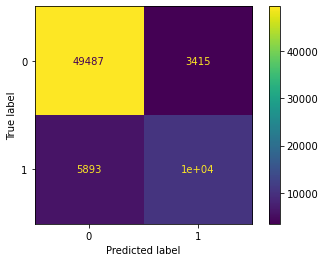

In [85]:
sklearn.metrics.plot_confusion_matrix(rf, xtest, ytest)

In [87]:
from sklearn.metrics import roc_auc_score

roc_auc_score(ytest, pred)

0.7864225745089488